In [1]:
import os
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ==== CONFIG ====
IMG_SIZE = 100
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/MachineLearning/FRUIT_KNN/fruit_images"
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/MachineLearning/FRUIT_KNN/knn_image_model.pkl"

In [3]:
# ==== FEATURE EXTRACTION ====
def extract_features(img):
    # Resize về 100x100x3
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- HOG ---
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   transform_sqrt=True, feature_vector=True)

    # --- LBP ---
    lbp = local_binary_pattern(gray, P=24, R=3, method="uniform")
    (hist_lbp, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, 24 + 3),
                                 range=(0, 24 + 2))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-6)

    # --- SURF (hoặc SIFT nếu SURF không có) ---
    try:
        surf = cv2.xfeatures2d.SURF_create(400)
    except:
        surf = cv2.SIFT_create()
    kp, des = surf.detectAndCompute(gray, None)
    if des is None:
        des = np.zeros((1, 64))  # tránh None
    surf_feat = des.mean(axis=0)  # lấy mean descriptor

    # --- Color Histogram ---
    chans = cv2.split(img)
    hist_color = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_color.extend(hist)
    hist_color = np.array(hist_color)

    # --- Gộp tất cả ---
    feature_vector = np.hstack([hog_feat, hist_lbp, surf_feat, hist_color])
    return feature_vector

In [4]:
# ==== LOAD DATA ====
def load_dataset(split_dir):
    X, y, labels = [], [], []
    for label, class_name in enumerate(sorted(os.listdir(split_dir))):
        class_path = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        labels.append(class_name)
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            img = cv2.imread(fpath)
            if img is None:
                continue
            feats = extract_features(img)
            X.append(feats)
            y.append(label)
    return np.array(X), np.array(y), labels

X_train, y_train, label_names = load_dataset(os.path.join(DATASET_DIR, "train"))
X_test, y_test, _ = load_dataset(os.path.join(DATASET_DIR, "test"))

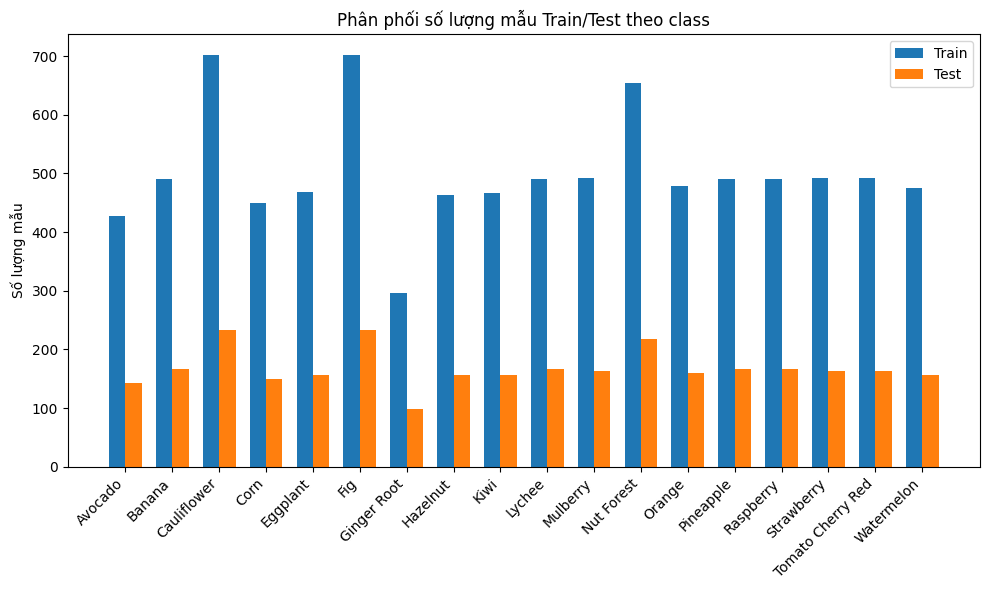

In [5]:
def plot_class_distribution(y_train, y_test, label_names):
    # Đếm số mẫu trong train và test theo class
    train_counts = [np.sum(y_train == i) for i in range(len(label_names))]
    test_counts = [np.sum(y_test == i) for i in range(len(label_names))]

    x = np.arange(len(label_names))  # vị trí cột
    width = 0.35

    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, train_counts, width, label="Train")
    plt.bar(x + width/2, test_counts, width, label="Test")

    plt.xticks(x, label_names, rotation=45, ha="right")
    plt.ylabel("Số lượng mẫu")
    plt.title("Phân phối số lượng mẫu Train/Test theo class")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_class_distribution(y_train, y_test, label_names)

In [6]:
# ==== KNN + GRIDSEARCH ====
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan", "cosine"],
}

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
Train score: 1.0
                   precision    recall  f1-score   support

          Avocado       0.91      1.00      0.95       143
           Banana       1.00      0.81      0.89       166
      Cauliflower       1.00      1.00      1.00       234
             Corn       0.92      0.61      0.73       150
         Eggplant       0.80      0.81      0.80       156
              Fig       0.98      1.00      0.99       234
      Ginger Root       0.97      0.87      0.91        99
         Hazelnut       0.98      1.00      0.99       157
             Kiwi       0.72      1.00      0.84       156
           Lychee       1.00      1.00      1.00       166
         Mulberry       1.00      1.00      1.00       164
       Nut Forest       1.00      0.87      0.93       218
           Orange       1.00      1.00      1.00       160
   

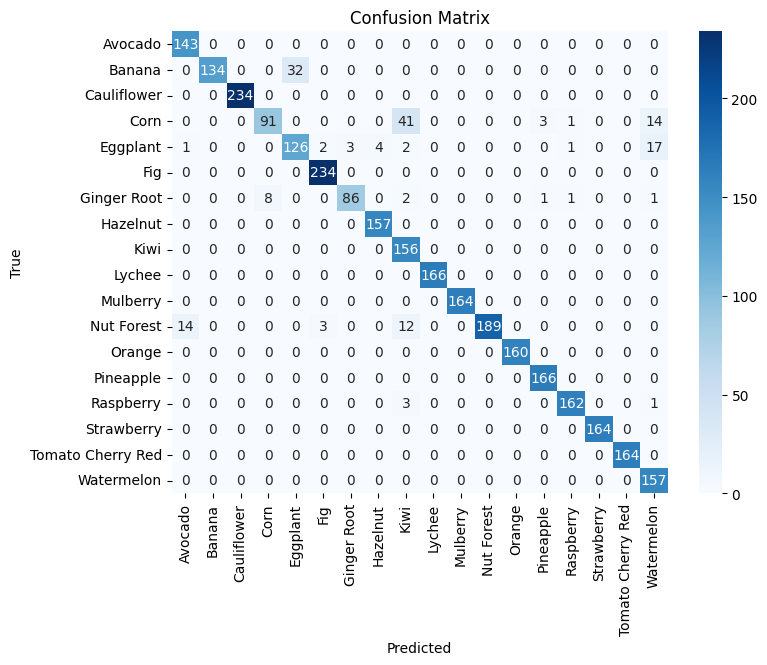

In [11]:
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Train score:", grid.best_score_)

# ==== TEST ====
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_names))

# ==== CONFUSION MATRIX ====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [13]:
# ==== SAVE MODEL ====
# model = grid.best_estimator_
joblib.dump((grid.best_estimator_, label_names), MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")

✅ Model saved to /content/drive/MyDrive/Colab Notebooks/MachineLearning/FRUIT_KNN/knn_image_model.pkl
